In [2]:
import warnings
warnings.simplefilter(action='ignore')

import anndata as ad
import pandas as pd
import numpy as np
import scanpy as sc
from itertools import chain
import episcanpy


import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import MultiMAP

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# load full rna and atac

In [6]:
data_dir = "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data"

In [7]:
rna = sc.read(f'{data_dir}/neurips-cite/rna.h5ad')

In [8]:
rna = rna.concatenate(sc.read(f'{data_dir}/neurips-multiome/rna.h5ad'), batch_key='concat_key', index_unique=None)

In [9]:
rna_pca = rna.copy()
sc.pp.scale(rna_pca)
sc.pp.pca(rna_pca)
rna.obsm['X_pca'] = rna_pca.obsm['X_pca'].copy()

In [10]:
del rna_pca

In [11]:
rna.write_h5ad("rna.h5ad")

In [12]:
# loading hvf only because full atac requires too much RAM. Below how to load the full dataset:
# atac = sc.read('/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-multiome/atac.h5ad')
atac = sc.read(f'{data_dir}/neurips-multiome/atac_hvf.h5ad')

In [ ]:
MultiMAP.TFIDF_LSI(atac)

In [ ]:
atac_X_lsi = atac.obsm['X_lsi'].copy()

In [ ]:
atac = sc.read(f'{data_dir}/neurips-multiome/atac.h5ad')

In [ ]:
# get atac_genes
atac.var.index = atac.var.index.map(lambda x: x.replace("-", ":", 1))
atac = episcanpy.tl.geneactivity(atac, gtf_file="gencode.v42.chr_patch_hapl_scaff.annotation.gtf")

In [ ]:
atac.obsm['X_lsi'] = atac_X_lsi.copy()
del atac_X_lsi

In [ ]:
# removing peaks that are mapped to the same gene. Duplicates will crash MultiMAP
atac = atac[:, ~atac.var.index.duplicated()]

In [ ]:
atac.obs.Modality = atac.obs.Modality.astype(str) + "_atac"
atac.obs.Modality = atac.obs.Modality.astype("category")

In [ ]:
adt = sc.read(f'{data_dir}/trimodal_neurips/adt.h5ad')

In [ ]:
adt_pca = adt.copy()
sc.pp.scale(adt_pca)
sc.pp.pca(adt_pca)
adt.obsm['X_pca'] = adt_pca.obsm['X_pca'].copy()
del adt_pca

In [ ]:
adt.obs.Modality = adt.obs.Modality.astype(str) + "_adt"
adt.obs.Modality = adt.obs.Modality.astype("category")

In [ ]:
[rna.shape, atac.shape, adt.shape]

In [60]:
# subsample of 30k samples, 10k per dataset
adata = MultiMAP.Integration([adt[adt.obs.index.isin(adt.obs.iloc[:10000].index)], rna[rna.obs.index.isin(rna.obs.iloc[:10000].index)], atac[atac.obs.index.isin(atac.obs.iloc[:10000].index)]], ['X_pca', 'X_pca', 'X_lsi'])

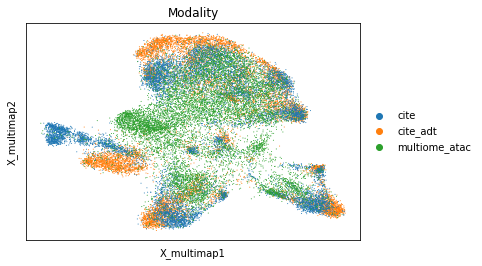

In [61]:
sc.pl.embedding(adata, 'X_multimap', color=["Modality"])

In [ ]:
# trimodal integration fails with anndata concatenation error: https://github.com/Teichlab/MultiMAP/issues/10
adata = MultiMAP.Integration([adt, rna, atac], ['X_pca', 'X_pca', 'X_lsi'])

In [ ]:
adata.write_h5ad("integrated.h5ad")

In [ ]:
sc.pl.embedding(adata, 'X_multimap', color=["Modality"])